In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg
from IPython.display import display, Math, Latex
import math # math module
from datetime import datetime
from pyts.decomposition import SingularSpectrumAnalysis 

In [3]:
data  = pd.read_csv('meditando.csv')
data2 = pd.read_csv('Jenny.csv')

In [4]:
canal1 = np.array(data['Dev1/ai0']*1000) #data canal 1 en mV
srate = 500
def sig_cut(signal,tstart,tlen,srate=500):
    n = len(signal)
    n_start = tstart*srate
    n_len = tlen*srate
    n_end = n_start+n_len
    cut = np.array([signal[i]for i in range(n_start,n_end)])
    return cut
signal= sig_cut(canal1,5,8)

In [5]:
eeg = np.array(data2['meditacion'])*1000 #registro EEG con 3 segundos de duración sr =500 hz
n_points = len(eeg)

## Defining functions

In [6]:
def SSA_r(signal, L):
    '''PREPARATION'''
    N = len(signal) #no. of points of signal
    K = N-L+1  #number of columns of matrix
    '''EMBEDDING'''
    X = np.array([[signal[i+j] for j in range(0,L)] for i in range(0,K)]) #Trajectory Matrix
    '''SVD'''
    Xh = X.transpose()
    S = np.matmul(Xh,X)
    U,s,V = linalg.svd(X)
    G = len(s)
    l = s**2 #Partial variances
    X_elem = []
    gkList = np.zeros(shape=(G,N))
    for k in range(0,G):
        Uk = U[:,k]
        Vk = V[k,:]
        X_k = s[k]*np.outer(Uk,Vk)
        X_elem.append(X_k)
        '''DIAGONAL AVERAGING'''
        gk = [] #list of values of time series
        for i in range(min(K-1,L-1),-max(K-1,L-1)-1,-1): # loop over diagonals
            gki=np.mean(np.diag(np.fliplr(X_k),i)) # successive time.series values
            gk.append(gki)
        gkList[k]=gk
#         for i in range(min(K-1,L-1),-max(K-1,L-1)-1,-1):
#             gki = np.mean(np.diag(np.fliplr(X_k),i))
#             gk.append(gki)
        gkList[k]=gk
    '''w-corr matrix'''
    w=[] # empty array to which to add successive weights
    LL=min(L,K)
    KK=max(L,K)
    for ll in range(1,LL+1): # first 1/3 part of weights
        w.append(ll)
    for ll in range(LL+1,KK+1): # second 1/3 part of weights
        w.append(LL)
    for ll in range(KK+1,N+1): # third 1/3 part of weights
        w.append(N-ll)
    kMin=kkMin=0 # show w-corr matrix for first 20 index values
    if L >= 20:
        kMax=kkMax=20
    else:
        kMax=kkMax=L
    #wMatriz=np.zeros(shape=(kMin,kMax)) # initial zero matrix  
    #for k in range(kMin,kMax):
        #for kk in range(kkMin,kkMax):
            #wMatriz[k][kk]=sum(w*gkList[k]*gkList[kk])/(math.sqrt(sum(w*gkList[k]*gkList[k]))*math.sqrt(sum(w*gkList[kk]*gkList[kk])))   
    wMatriz=[[sum(w*gkList[k]*gkList[kk])/(math.sqrt(sum(w*gkList[k]*gkList[k]))*math.sqrt(sum(w*gkList[kk]*gkList[kk]))) for k in range(kMin,kMax)] for kk in range(kkMin,kkMax)]
    wMatriz=np.array(wMatriz)
    return (G, l, gkList, wMatriz)

'''ScreeSSA function retrieved from Fossion,R.(2018)
Thank you Dr. Fossion! '''
def ScreeSSA(Serie,L): # 2 <= L <= N/2
    from scipy import linalg # linear algebra (matrix) processing package
    N=len(Serie)
    K=N-L+1
    X=np.array([[Serie[i+j] for j in range(0,L)] for i in range(0,K)]) # trajectory matrix
    s=linalg.svd(X,compute_uv=False) # descomposición en valores singulares 
    l=s**2 # partial variances
    return l;    


### Applying the code

In [7]:
'''Info about the data'''
data_info ='''About this EEG series:\n \n Length: {}  points - {} seconds 
 Sample rate {} Hz \n Average value {} \n Expressed in {} units'''
print(data_info.format(n_points,n_points/500,500,np.mean(eeg),'mV'))

About this EEG series:
 
 Length: 1500  points - 3.0 seconds 
 Sample rate 500 Hz 
 Average value 7.6037040586 
 Expressed in mV units


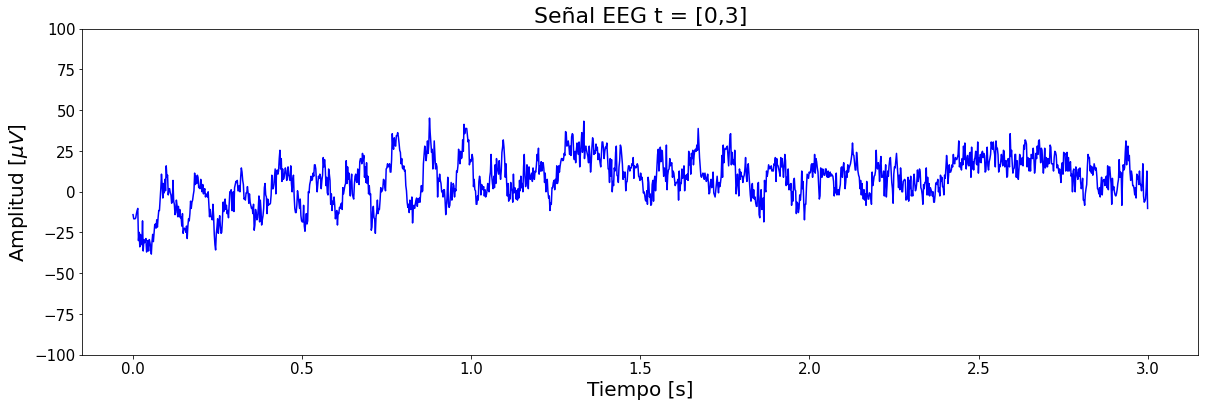

In [8]:
import EEG as tl
import re
tl.eeg_plot(eeg,0,3,-100,100)

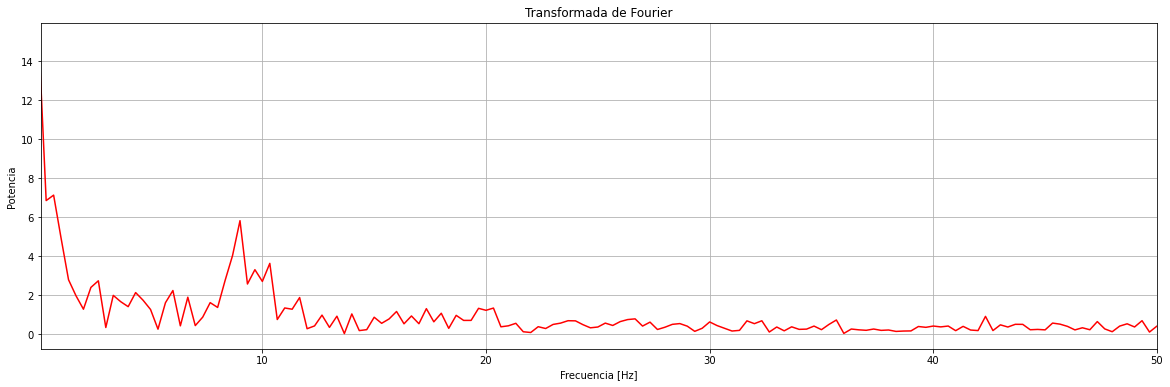

In [9]:
tl.FFT(eeg,500,50)

Time= 2021-06-08 16:19:24.995605
Time= 2021-06-08 16:19:25.045578


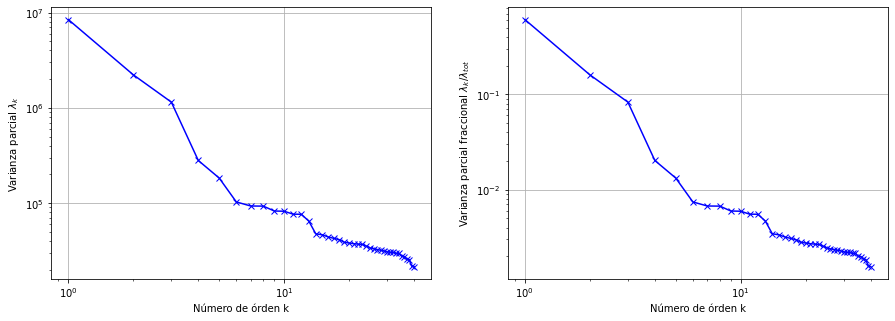

In [10]:
print('Time=',str(datetime.now()))
L=40
l=ScreeSSA(eeg,L)
print('Time=',str(datetime.now()))
k=np.arange(len(l))
k=k+1
fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(k,l,'-x',color='blue')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('Número de órden k')
axs[0].set_ylabel(r'Varianza parcial $\lambda_k$')
axs[0].grid()

axs[1].plot(k,l/sum(l),'-x',color='blue')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('Número de órden k')
axs[1].set_ylabel(r'Varianza parcial fraccional $\lambda_k/\lambda_{tot}$')
axs[1].grid()
plt.show()

Time= 2021-06-08 16:19:26.750427
Time= 2021-06-08 16:19:26.795402


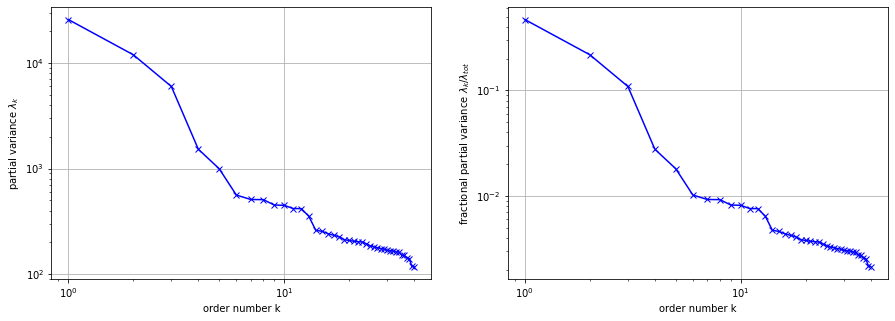

In [11]:
print('Time=',str(datetime.now()))
L=40
Norm_series= (eeg-np.mean(eeg))/np.std(eeg)
l=ScreeSSA(Norm_series,L)
print('Time=',str(datetime.now()))
k=np.arange(len(l))
k=k+1
fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(k,l,'-x',color='blue')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('order number k')
axs[0].set_ylabel(r'partial variance $\lambda_k$')
axs[0].grid()

axs[1].plot(k,l/sum(l),'-x',color='blue')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_xlabel('order number k')
axs[1].set_ylabel(r'fractional partial variance $\lambda_k/\lambda_{tot}$')
axs[1].grid()

plt.show()

In [12]:
tin=datetime.now()
print('Time @ start =',str(datetime.now()))
r,l,gklist,wMatrix = SSA_r(eeg,L=40)
tfin = datetime.now()
print('Time @ end =',str(datetime.now()))
delta = tfin-tin
sec,milisec = re.findall('\d+',str(delta))[2],re.findall('\d+',str(delta))[3]
print(f'SSA decomposition completed! It only took {sec} sec with {milisec} milisec!')

Time @ start = 2021-06-08 16:19:28.536306
Time @ end = 2021-06-08 16:19:30.629204
SSA decomposition completed! It only took 02 sec with 092898 milisec!


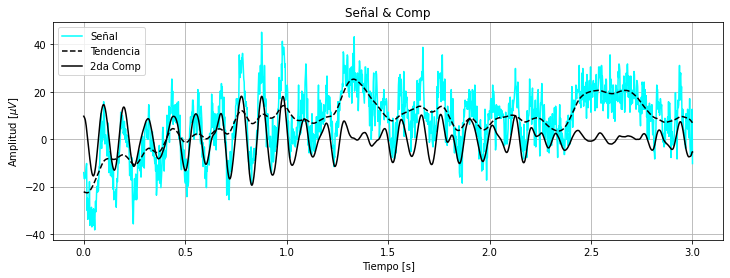

In [13]:
Trend = gklist[0]
C2nd = gklist[1]+gklist[2]
# C3rd = gklist[3]+gklist[4]
time=np.linspace(0,3,n_points)
plt.figure(figsize=(12,4))
plt.plot(time,eeg,c='cyan',label='Señal')
plt.plot(time,Trend,'--',color='black',label='Tendencia')
plt.plot(time,C2nd,color='black',label='2da Comp')
# plt.plot(time,C3rd,color='black',label='3rd Comp')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [$\mu V$]')
plt.title('Señal & Comp')
plt.legend()
plt.grid()
plt.show()

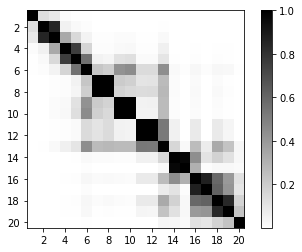

In [14]:
x=np.arange(1, 20, 2)
y=x+1
plt.imshow(wMatrix,cmap=plt.cm.binary);
plt.colorbar()
plt.xticks(x,y)
plt.yticks(x,y)
plt.show()

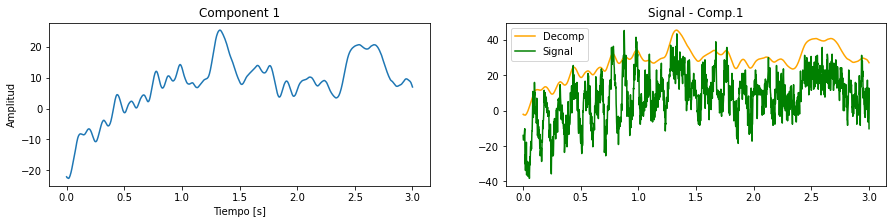

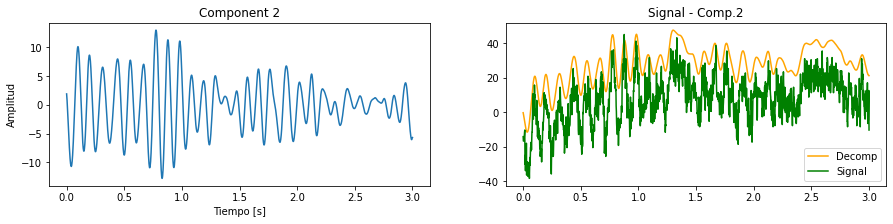

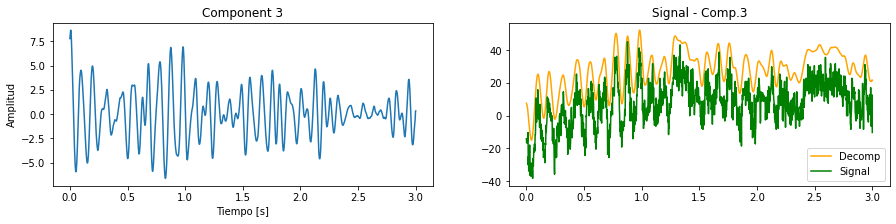

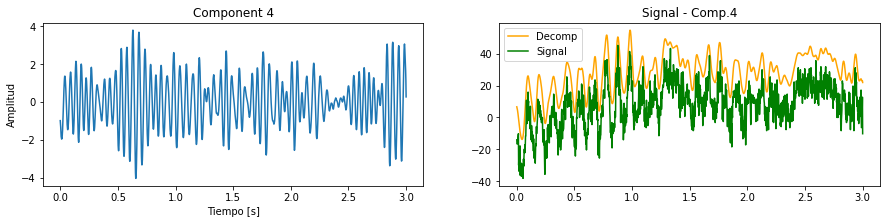

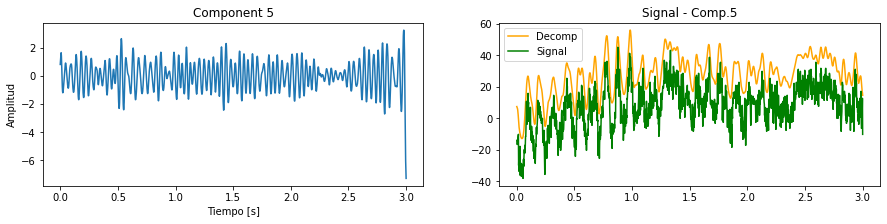

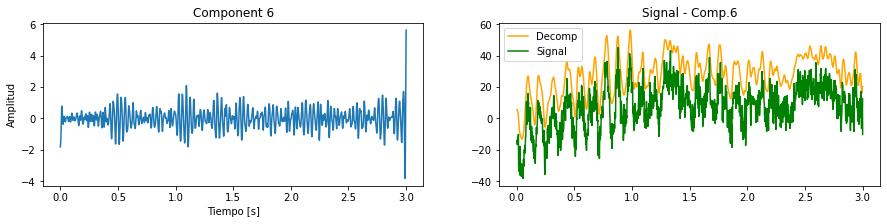

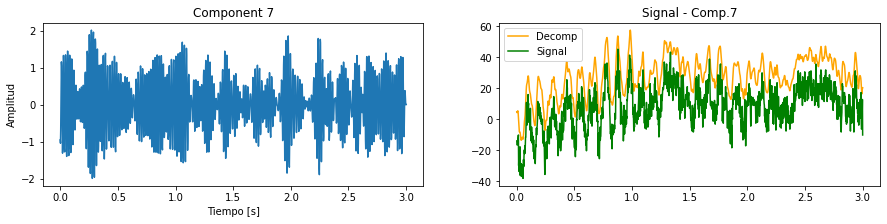

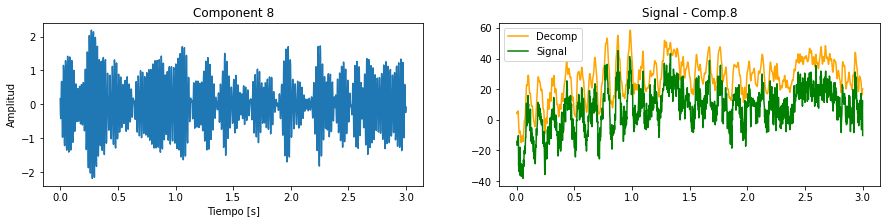

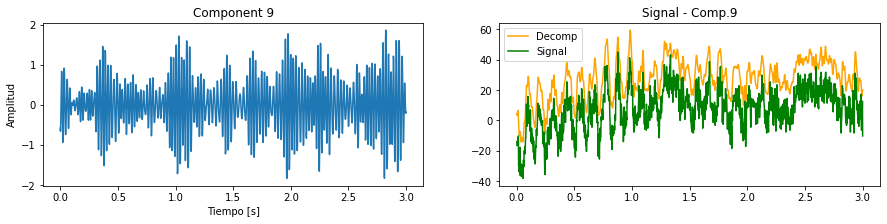

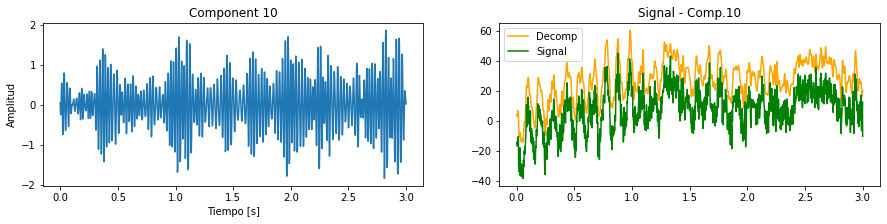

In [15]:
result = gklist[0]
for i in range(0,10,1): #ciclo para avanzar y graficar las primeras 5 componentes
    fig,axs = plt.subplots(1,2,figsize=(15,3)) #Definición de figuras con subgráficas
    axs[0].plot(time,gklist[i]) #Primera gráfica - Componente i 
    axs[0].set_title(f'Component {i+1}') 
    axs[0].set_ylabel('Amplitud')
    axs[0].set_xlabel('Tiempo [s]')
    if i ==0:
        result = gklist[i]
    else:
        result = result + gklist[i]
    axs[1].plot(time,result+20,'orange',label='Decomp') #Segunda gráfica, señal - componente i
    axs[1].plot(time,eeg,c='green',label='Signal') #Gráfica de señal original 
    axs[1].set_title(f'Signal - Comp.{i+1}')
    axs[1].legend()

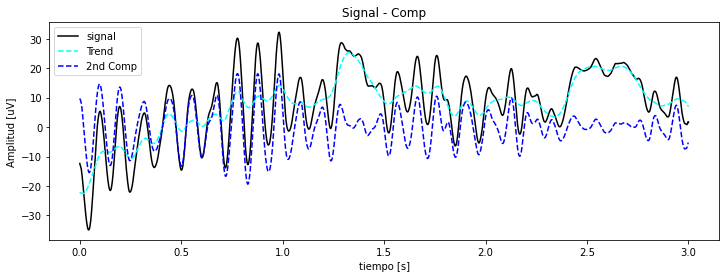

In [16]:
Trend = gklist[0]
C2nd = gklist[1]+gklist[2]
time=np.linspace(0,3,n_points)
plt.figure(figsize=(12,4))
plt.plot(time,Trend+C2nd,c='black',label='signal')
plt.plot(time,Trend,'--',color='cyan',label='Trend')
plt.plot(time,C2nd,'--',color='blue',label='2nd Comp')
plt.xlabel('tiempo [s]')
plt.ylabel('Amplitud [uV]')
plt.title('Signal - Comp')
plt.legend()
plt.show()

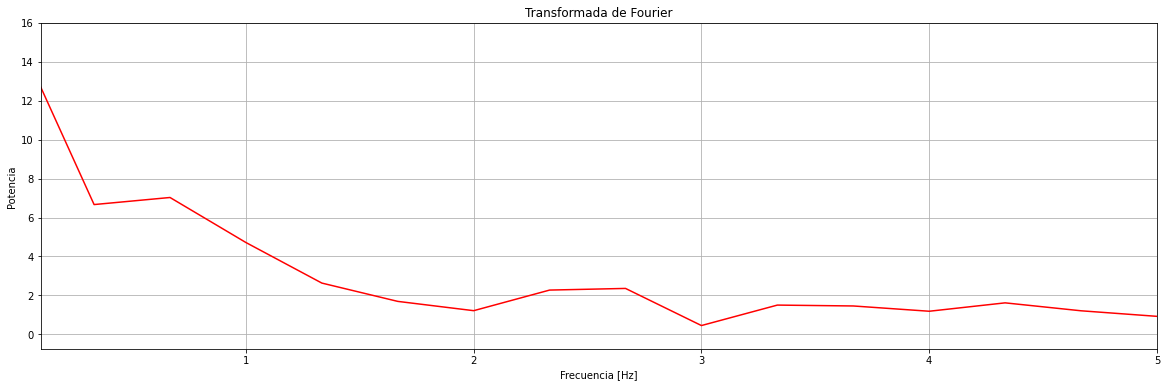

In [17]:
tl.FFT(Trend,500,5)

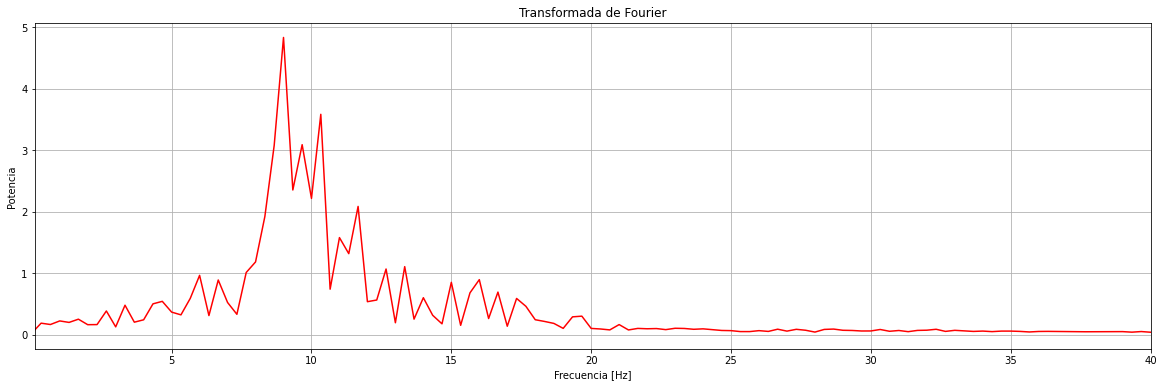

In [18]:
tl.FFT(C2nd,500,40)

In [19]:
import wavelets as wv

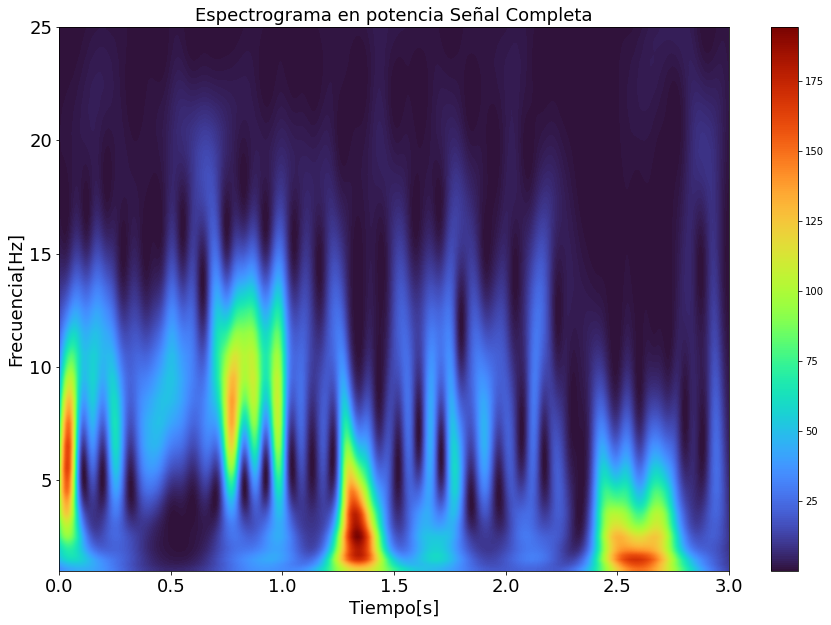

In [20]:
fi = 1 #frecuencia inicial
ff = 25 #frecuencia final
resf = 0.2 #resolución espectral
time_s = 3 #tiempo en segundos de la señal
S_WD = wv.MRA(eeg,fi,ff,resf,wv.morlet,500)

plt.figure(figsize=(15,10))
plt.imshow(S_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo')
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('Tiempo[s]',fontsize =18)
plt.ylabel('Frecuencia[Hz]',fontsize =18)
plt.title('Espectrograma en potencia Señal Completa',fontsize =18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

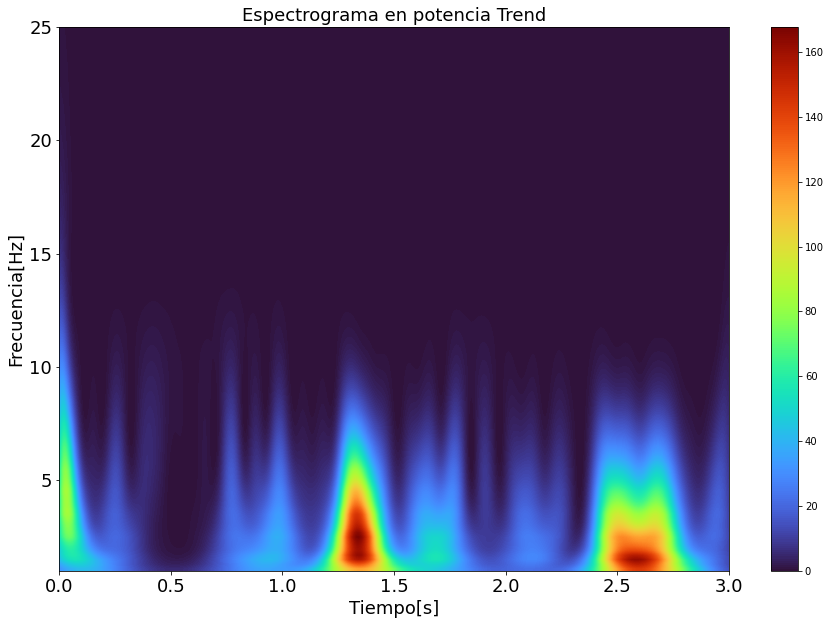

In [21]:
fi = 1 #frecuencia inicial
ff = 25 #frecuencia final
resf = 0.2 #resolución espectral
time_s = 3 #tiempo en segundos de la señal
T_WD = wv.MRA(Trend,fi,ff,resf,wv.morlet,500)

plt.figure(figsize=(15,10))
plt.imshow(T_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo')
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('Tiempo[s]',fontsize =18)
plt.ylabel('Frecuencia[Hz]',fontsize =18)
plt.title('Espectrograma en potencia Trend',fontsize =18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

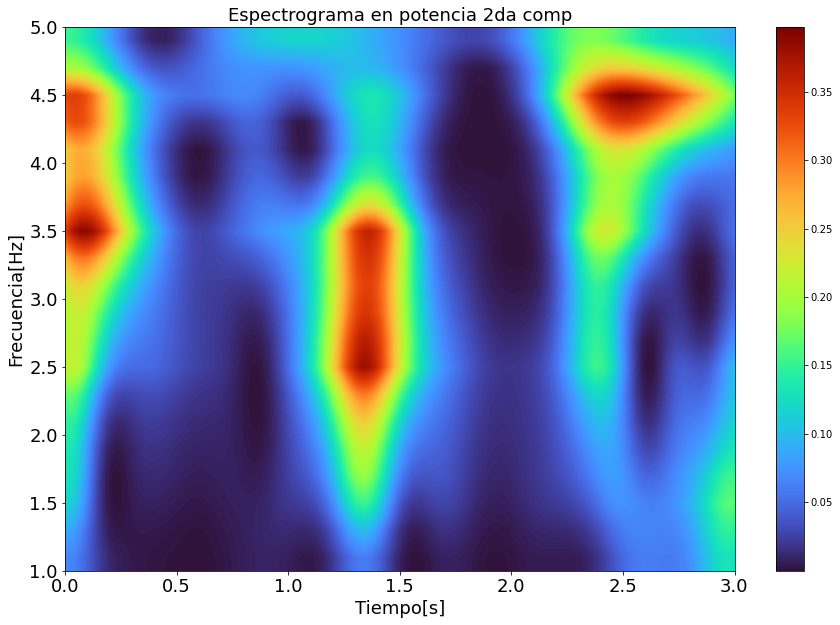

In [22]:
fi = 1 #frecuencia inicial
ff = 5 #frecuencia final
resf = 0.2 #resolución espectral
time_s = 3 #tiempo en segundos de la señal
T_WD = wv.MRA(C2nd,fi,ff,resf,wv.morlet,500)

plt.figure(figsize=(15,10))
plt.imshow(T_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo')
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel('Tiempo[s]',fontsize =18)
plt.ylabel('Frecuencia[Hz]',fontsize =18)
plt.title('Espectrograma en potencia 2da comp',fontsize =18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [322]:
"Plotting ave. correlation por different window we look for L with lowest aveCorr"
Lmin=20
Lmax=750
dL=10
X_list = np.arange(Lmin,Lmax+dL,dL)
Y_list = []
p_info = 'Time = {} ; W-Length = {} ; avgCorr = {}'
for L in range(Lmin,Lmax+dL,dL):
    r,l,gklist,wMatrix = SSA_r(eeg,L)
    ave_Corr = (sum(wMatrix[1,:])-wMatrix[1,1]+sum(wMatrix[2,:])-wMatrix[2,2])/38
    #ave_Corr = (sum(wMatrix[0,0:])+wMatrix[1,0]+sum(wMatrix[1,1:])+sum(wMatrix[2,0:2])+sum(wMatrix[2,2:]))/57
    Y_list.append(ave_Corr)
    if (L%10)==0:
        print(p_info.format(str(datetime.now())[11:19],L,ave_Corr))

Time = 15:29:29 ; W-Length = 20 ; avgCorr = 0.07025978339209682
Time = 15:29:31 ; W-Length = 30 ; avgCorr = 0.07180559846683167
Time = 15:29:33 ; W-Length = 40 ; avgCorr = 0.07082460640852566
Time = 15:29:35 ; W-Length = 50 ; avgCorr = 0.06328518079369393
Time = 15:29:38 ; W-Length = 60 ; avgCorr = 0.0726478416230786
Time = 15:29:40 ; W-Length = 70 ; avgCorr = 0.07885490774967649
Time = 15:29:43 ; W-Length = 80 ; avgCorr = 0.08021742972453687
Time = 15:29:47 ; W-Length = 90 ; avgCorr = 0.08555761437895813
Time = 15:29:51 ; W-Length = 100 ; avgCorr = 0.08595988643611942
Time = 15:29:55 ; W-Length = 110 ; avgCorr = 0.08868107147054985
Time = 15:29:59 ; W-Length = 120 ; avgCorr = 0.09269154369163068
Time = 15:30:04 ; W-Length = 130 ; avgCorr = 0.09288192672449254
Time = 15:30:08 ; W-Length = 140 ; avgCorr = 0.09697552623022605
Time = 15:30:14 ; W-Length = 150 ; avgCorr = 0.10017352132073949
Time = 15:30:19 ; W-Length = 160 ; avgCorr = 0.09974610873644527
Time = 15:30:24 ; W-Length = 170 ;

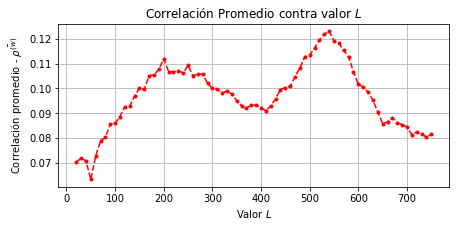

In [323]:
plt.figure(figsize=(7,3))
plt.plot(X_list,Y_list,'r.--')
plt.title('Correlación Promedio contra valor $L$')
plt.xlabel('Valor $L$')
plt.ylabel(r'Correlación promedio - $\bar{\rho^{(w)}}$')
plt.grid()

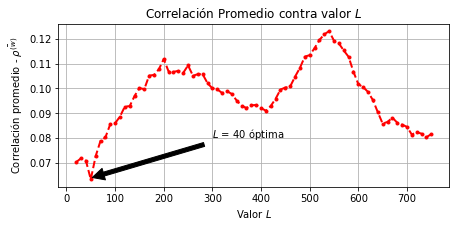

In [324]:
fig, ax = plt.subplots(figsize=(7,3))

line, = ax.plot(X_list, Y_list,'r.--', lw=2,)

ax.annotate('$L$ = 40 óptima ', xy=(40, np.array(Y_list).min()), xytext=(300, 0.08),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.title('Correlación Promedio contra valor $L$')
plt.xlabel('Valor $L$')
plt.ylabel(r'Correlación promedio - $\bar{\rho^{(w)}}$')
plt.grid()
plt.show()


In [18]:
"Plotting ave. correlation por different window we look for L with lowest aveCorr"
Lmin=4
Lmax=40
dL=1
X_list2 = np.arange(Lmin,Lmax+dL,dL)
Y_list2 = []
p_info = 'Time = {} ; W-Length = {} ; avgCorr = {}'
for Lvar in range(Lmin,Lmax+dL,dL):
    r,l,gklist,wMatrix = SSA_r(eeg,Lvar)
    if Lvar <20:
        ave_Corr = (sum(wMatrix[1,:])-wMatrix[1,1]+sum(wMatrix[2,:])-wMatrix[2,2])/(2*Lvar-2)
    #ave_Corr = (sum(wMatrix[0,0:])+wMatrix[1,0]+sum(wMatrix[1,1:])+sum(wMatrix[2,0:2])+sum(wMatrix[2,2:]))/57
        Y_list2.append(ave_Corr)
    else:
        ave_Corr = (sum(wMatrix[1,:])-wMatrix[1,1]+sum(wMatrix[2,:])-wMatrix[2,2])/(38)
        Y_list2.append(ave_Corr)
    if (L%1)==0:
        print(p_info.format(str(datetime.now())[11:19],Lvar,ave_Corr))

Time = 17:06:45 ; W-Length = 4 ; avgCorr = 0.3085849686055288
Time = 17:06:45 ; W-Length = 5 ; avgCorr = 0.2933418137124962
Time = 17:06:46 ; W-Length = 6 ; avgCorr = 0.2503151132934266
Time = 17:06:46 ; W-Length = 7 ; avgCorr = 0.21904557932848565
Time = 17:06:46 ; W-Length = 8 ; avgCorr = 0.18786740665015625
Time = 17:06:47 ; W-Length = 9 ; avgCorr = 0.16285700250364307
Time = 17:06:47 ; W-Length = 10 ; avgCorr = 0.14247733021407288
Time = 17:06:48 ; W-Length = 11 ; avgCorr = 0.12663944176033837
Time = 17:06:48 ; W-Length = 12 ; avgCorr = 0.11492765396320798
Time = 17:06:49 ; W-Length = 13 ; avgCorr = 0.10520680552332584
Time = 17:06:50 ; W-Length = 14 ; avgCorr = 0.09705917504820533
Time = 17:06:50 ; W-Length = 15 ; avgCorr = 0.09203161779890547
Time = 17:06:51 ; W-Length = 16 ; avgCorr = 0.08862112637495555
Time = 17:06:52 ; W-Length = 17 ; avgCorr = 0.08452427838140067
Time = 17:06:53 ; W-Length = 18 ; avgCorr = 0.08004693655104604
Time = 17:06:54 ; W-Length = 19 ; avgCorr = 0.074

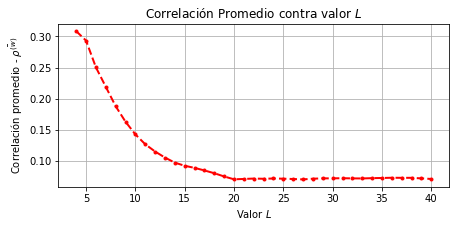

In [19]:
fig, ax = plt.subplots(figsize=(7,3))

line, = ax.plot(X_list2, Y_list2,'r.-', lw=2,)

# ax.annotate('$L$ = 40 óptima ', xy=(40, np.array(Y_list).min()), xytext=(300, 0.08),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )
plt.title('Correlación Promedio contra valor $L$')
plt.xlabel('Valor $L$')
plt.ylabel(r'Correlación promedio - $\bar{\rho^{(w)}}$')
plt.grid()
plt.show()


In [20]:
"Plotting ave. correlation por different window we look for L with lowest aveCorr"
Lmin=40
Lmax=90
dL=1
X_list3 = np.arange(Lmin,Lmax+dL,dL)
Y_list3 = []
p_info = 'Time = {} ; W-Length = {} ; avgCorr = {}'
for Lvar in range(Lmin,Lmax+dL,dL):
    r,l,gklist,wMatrix = SSA_r(eeg,Lvar)
    if Lvar <20:
        ave_Corr = (sum(wMatrix[1,:])-wMatrix[1,1]+sum(wMatrix[2,:])-wMatrix[2,2])/(2*Lvar-2)
    #ave_Corr = (sum(wMatrix[0,0:])+wMatrix[1,0]+sum(wMatrix[1,1:])+sum(wMatrix[2,0:2])+sum(wMatrix[2,2:]))/57
        Y_list2.append(ave_Corr)
    else:
        ave_Corr = (sum(wMatrix[1,:])-wMatrix[1,1]+sum(wMatrix[2,:])-wMatrix[2,2])/(38)
        Y_list3.append(ave_Corr)
    if (L%1)==0:
        print(p_info.format(str(datetime.now())[11:19],Lvar,ave_Corr))

Time = 17:07:28 ; W-Length = 40 ; avgCorr = 0.07082460640852566
Time = 17:07:30 ; W-Length = 41 ; avgCorr = 0.06984509435677073
Time = 17:07:32 ; W-Length = 42 ; avgCorr = 0.06849240034232759
Time = 17:07:34 ; W-Length = 43 ; avgCorr = 0.06749197160383565
Time = 17:07:36 ; W-Length = 44 ; avgCorr = 0.06643924138422301
Time = 17:07:37 ; W-Length = 45 ; avgCorr = 0.06557286648475663
Time = 17:07:39 ; W-Length = 46 ; avgCorr = 0.06483240932455808
Time = 17:07:41 ; W-Length = 47 ; avgCorr = 0.06419926699930502
Time = 17:07:43 ; W-Length = 48 ; avgCorr = 0.06373906866137435
Time = 17:07:45 ; W-Length = 49 ; avgCorr = 0.06345274286929618
Time = 17:07:47 ; W-Length = 50 ; avgCorr = 0.06328518079369393
Time = 17:07:49 ; W-Length = 51 ; avgCorr = 0.0633369895468823
Time = 17:07:51 ; W-Length = 52 ; avgCorr = 0.06374240559987727
Time = 17:07:53 ; W-Length = 53 ; avgCorr = 0.06428076940881107
Time = 17:07:55 ; W-Length = 54 ; avgCorr = 0.06480650882864805
Time = 17:07:58 ; W-Length = 55 ; avgCorr

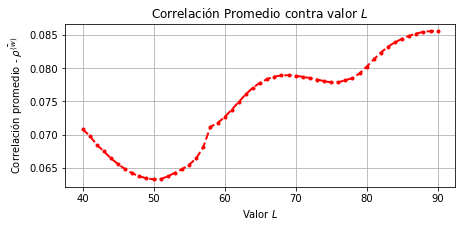

In [29]:
fig, ax = plt.subplots(figsize=(7,3))

line, = ax.plot(X_list3, Y_list3,'r.--', lw=2,)

# ax.annotate('$L$ = 40 óptima ', xy=(40, np.array(Y_list).min()), xytext=(300, 0.08),
#             arrowprops=dict(facecolor='black', shrink=0.05),
#             )
plt.title('Correlación Promedio contra valor $L$')
plt.xlabel('Valor $L$')
plt.ylabel(r'Correlación promedio - $\bar{\rho^{(w)}}$')
plt.grid()
plt.show()


### SSA para distintas ondas 
Theta $\rightarrow f_c = 6 Hz \Rightarrow L_{\lambda} = 83$ 


Alfa $\rightarrow f_c = 10 Hz \Rightarrow L_{\lambda} = 50$


Beta $\rightarrow f_c = 22 Hz \Rightarrow L_{\lambda} = 23$


Gamma $\rightarrow f_c = 40 Hz \Rightarrow L_{\lambda} = 12$

In [47]:
T_theta= 1/6
T_alfa = 1/10
T_beta = 1/22
T_gama = 1/40
T_lambda = []
True_lambda_theta = 83*2/T_theta
True_lambda_alfa = 50*2/T_alfa
True_lambda_beta = 23*2/T_beta
True_lambda_gama = 12*2/T_gama
T_lambda.append(True_lambda_theta)
T_lambda.append(True_lambda_alfa)
T_lambda.append(True_lambda_beta)
T_lambda.append(True_lambda_gama)
for i in T_lambda:
    print(i)


996.0
1000.0
1012.0
960.0


Time @ start = 2021-06-08 16:31:11.685513
Time @ end = 2021-06-08 16:31:36.185597
SSA decomposition completed! It only took 24 sec with 500084 milisec!


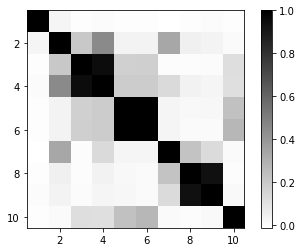

In [54]:
L_l = int(len(eeg)/2)
N_comp=10
tin=datetime.now()
print('Time @ start =',str(datetime.now()))
r,l,gklist,wMatrix = SSA_r(eeg,L_l)
tfin = datetime.now()
print('Time @ end =',str(datetime.now()))
delta = tfin-tin
sec,milisec = re.findall('\d+',str(delta))[2],re.findall('\d+',str(delta))[3]
print(f'SSA decomposition completed! It only took {sec} sec with {milisec} milisec!')
x=np.arange(1, N_comp, 2)
y=x+1
plt.imshow(wMatrix[0:N_comp,0:N_comp],cmap=plt.cm.binary);
plt.colorbar()
plt.xticks(x,y)
plt.yticks(x,y)
plt.show()

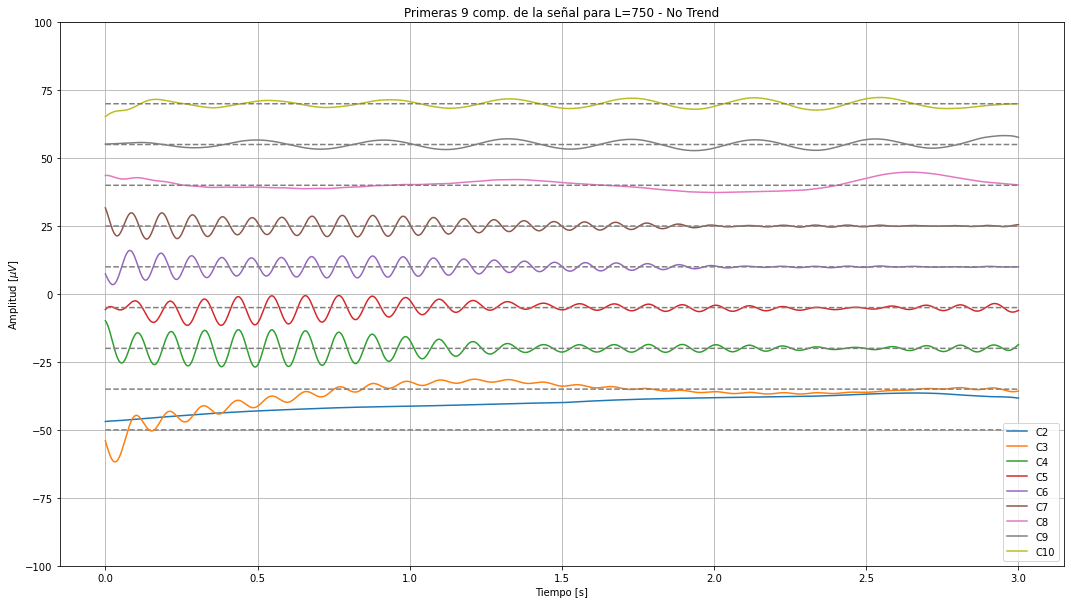

In [55]:
fig,ax = plt.subplots(1,1,figsize=(18,10))
for i in range (9):
    ax.plot(time,gklist[i]-50+i*15,label=f'C{i+2}')
    ax.plot(time,np.ones(1500)*(-50)+(i*15),'--',c='gray')
    ax.set_xlabel('Tiempo [s]')
    ax.set_ylabel('Amplitud [$\mu V$]')
    ax.set_title(f'Primeras {N_comp-1} comp. de la señal para L={L_l} - No Trend')
    ax.set_ylim(-100,100)
ax.legend()
ax.grid()
plt.savefig(f'SSA/Results/{N_comp-1}comp-L={L_l}-NoTrend.jpeg', dpi=300)

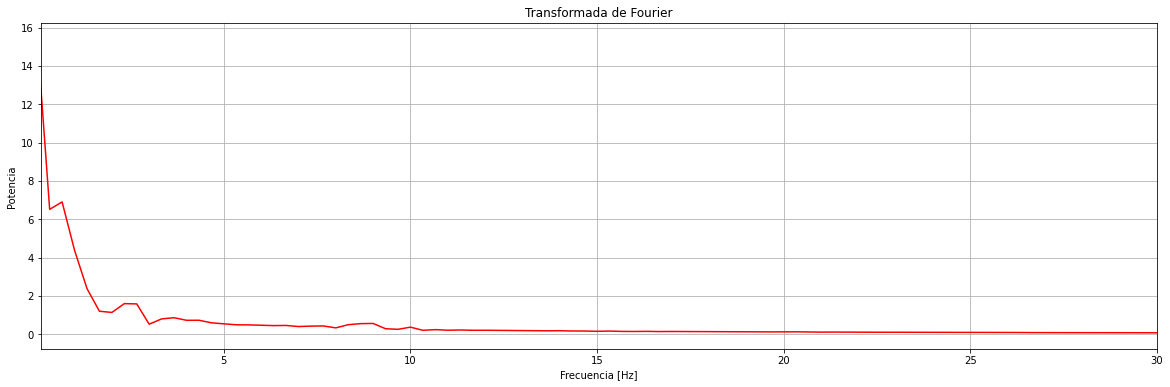

In [25]:
tl.FFT(gklist[0],500,30)

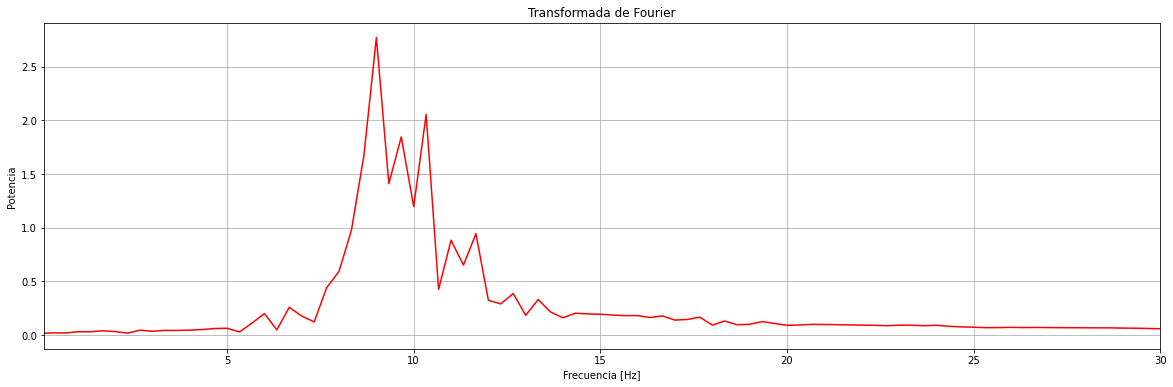

In [26]:
tl.FFT(gklist[1],500,30)

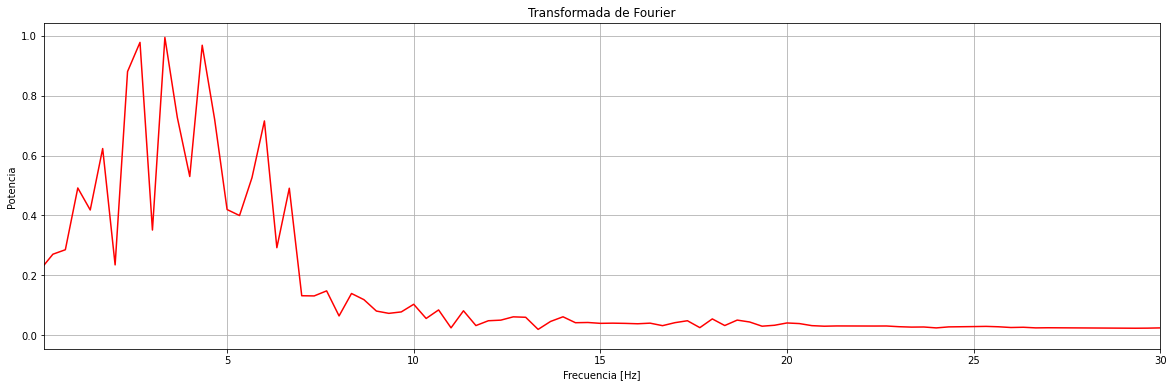

In [27]:
tl.FFT(gklist[3],500,30)

In [28]:
Trend = gklist[0]+gklist[4]
C2nd = gklist[1]+gklist[2]
C3rd = sum(gklist)-Trend - C2nd

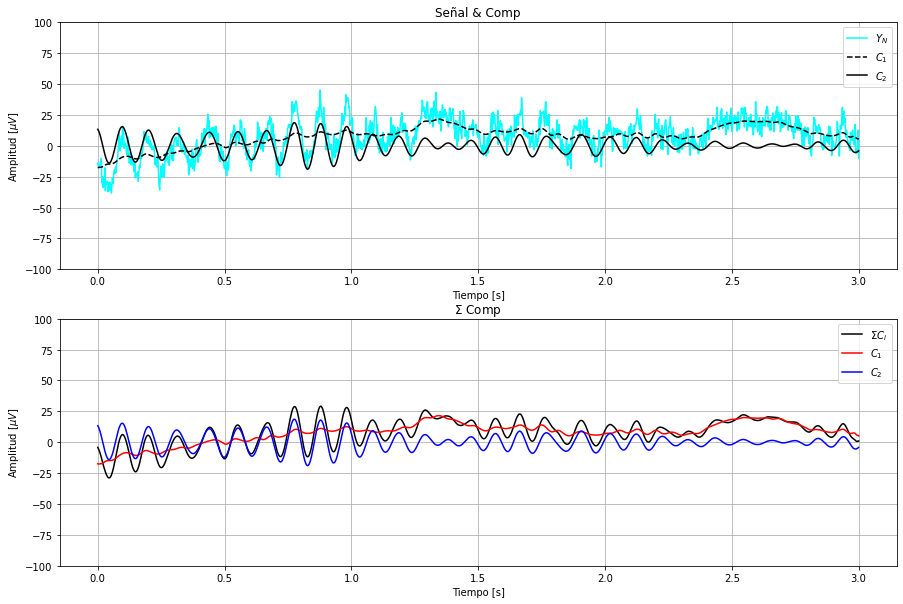

In [29]:
time=np.linspace(0,3,n_points)
fig,ax = plt.subplots(2,1,figsize=(15,10))

ax[0].plot(time,eeg,c='cyan',label='$Y_N$')
ax[0].plot(time,Trend,'--',color='black',label='$C_1$')
ax[0].plot(time,C2nd,color='black',label='$C_2$')
ax[0].set_xlabel('Tiempo [s]')
ax[0].set_ylabel('Amplitud [$\mu V$]')
ax[0].set_title('Señal & Comp')
ax[0].set_ylim(-100,100)
ax[0].legend()
ax[0].grid()

ax[1].plot(time,Trend+C2nd,c='black',label='$\Sigma C_i$')
ax[1].plot(time,Trend,'-',color='red',label='$C_1$')
ax[1].plot(time,C2nd,'-',color='blue',label='$C_2$')
ax[1].set_xlabel('Tiempo [s]')
ax[1].set_ylabel('Amplitud [$\mu V$]')
ax[1].set_title('$\Sigma$ Comp')
ax[1].set_ylim(-100,100)
ax[1].legend()
ax[1].grid()

# ax[2].plot(time,C3rd,c='black',label='$C_3$')
# ax[2].set_xlabel('Tiempo [s]')
# ax[2].set_ylabel('Amplitud [$\mu V$]')
# ax[2].set_title('$\Sigma$ Comp')
# ax[2].set_ylim(-100,100)
# ax[2].legend()
# ax[2].grid()
plt.show()

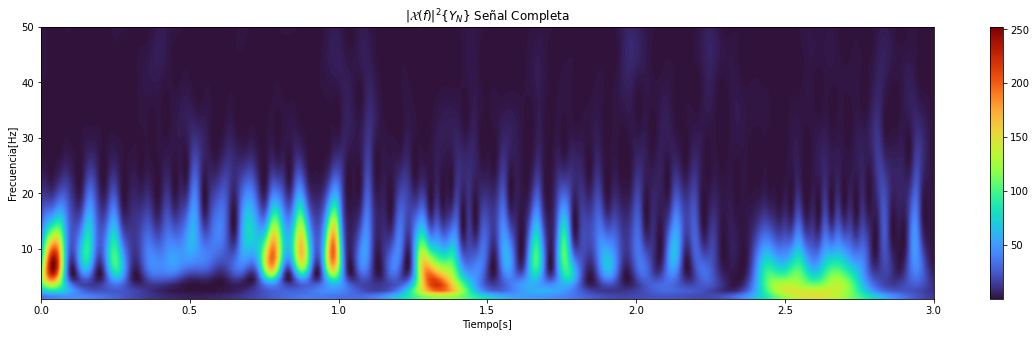

In [30]:
time=np.linspace(0,3,n_points)
fi = 1 #frecuencia inicial
ff = 50 #frecuencia final
resf = 1 #resolución espectral
time_s = 3 #tiempo en segundos de la señal
fig,ax = plt.subplots(1,1,figsize=(20,5))


T_WD = wv.MRA(eeg,fi,ff,resf,wv.morlet,500)
ax.imshow(T_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo')
ax.set_xlabel('Tiempo[s]')
ax.set_ylabel('Frecuencia[Hz]')
ax.set_title(r'$|\mathcal{X}(f)|^2 \{ Y_N \}$ Señal Completa')
fig.colorbar(plt.imshow(T_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo'))
ax.invert_yaxis()
plt.show()

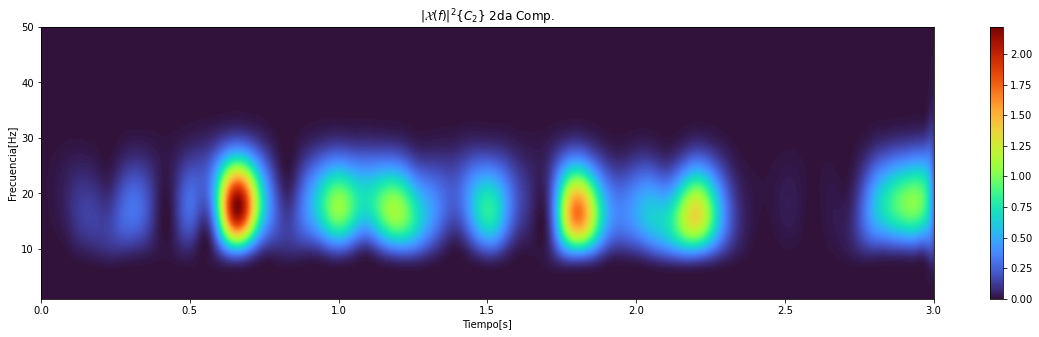

In [31]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

T_WD = wv.MRA(gklist[5],fi,ff,resf,wv.morlet,500)
ax.imshow(T_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo')
ax.invert_yaxis()
ax.set_xlabel('Tiempo[s]')
ax.set_ylabel('Frecuencia[Hz]')
ax.set_title(r'$|\mathcal{X}(f)|^2 \{ C_2 \}$ 2da Comp.')
fig.colorbar(plt.imshow(T_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo'))
ax.invert_yaxis()
plt.show()

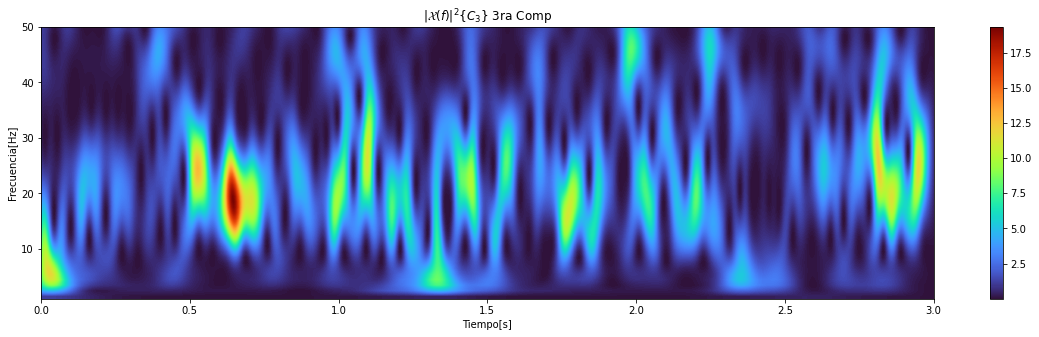

In [32]:
fig,ax = plt.subplots(1,1,figsize=(20,5))

T_WD = wv.MRA(C3rd,fi,ff,resf,wv.morlet,500)
ax.imshow(T_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo')
ax.invert_yaxis()
ax.set_xlabel('Tiempo[s]')
ax.set_ylabel('Frecuencia[Hz]')
ax.set_title(r'$|\mathcal{X}(f)|^2 \{ C_3 \}$ 3ra Comp')
fig.colorbar(plt.imshow(T_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo'))
ax.invert_yaxis()
plt.show()

In [33]:
# TC2 = 2*np.sin(time*10+2*np.pi)
# TC1 = 20*np.sin(time*6+2*np.pi)
# TC3 = 10*np.sin(time*22+2*np.pi)
# TC4 = 5*np.sin(time*40+2*np.pi)
# Test = TC1+TC2+TC3+TC4
# plt.plot(time,Test)
# plt.xlabel('Tiempo [s]')
# plt.ylabel('Amplitud [$\mu V$]')
# plt.title('Señal de prueba')
# plt.ylim(-100,100)

In [34]:
# L_l = 50
# tin=datetime.now()
# print('Time @ start =',str(datetime.now()))
# r,l,gklist,wMatrix = SSA_r(Test,L_l)
# tfin = datetime.now()
# print('Time @ end =',str(datetime.now()))
# delta = tfin-tin
# sec,milisec = re.findall('\d+',str(delta))[2],re.findall('\d+',str(delta))[3]
# print(f'SSA decomposition completed! It only took {sec} sec with {milisec} milisec!')
# x=np.arange(1, 20, 2)
# y=x+1
# plt.imshow(wMatrix,cmap=plt.cm.binary);
# plt.colorbar()
# plt.xticks(x,y)
# plt.yticks(x,y)
# plt.show()

In [35]:
gama_c1 = gklist[0]+gklist[1]
gama_c2 = gklist[1]+gklist[2]
gama_c3 = sum(gklist)-Trend - C2nd

In [36]:
beta_c1 = gklist[0]+gklist[1]
beta_c2 = gklist[1]+gklist[2]
beta_c3 = sum(gklist)-Trend - C2nd

In [37]:
alfa_c1 = gklist[0]
alfa_c2 = gklist[1]+gklist[2]
alfa_c3 = sum(gklist)-Trend - C2nd

In [38]:
teta_c1 = gklist[0]
teta_c2 = gklist[1]+gklist[2]
teta_c3 = sum(gklist)-Trend - C2nd

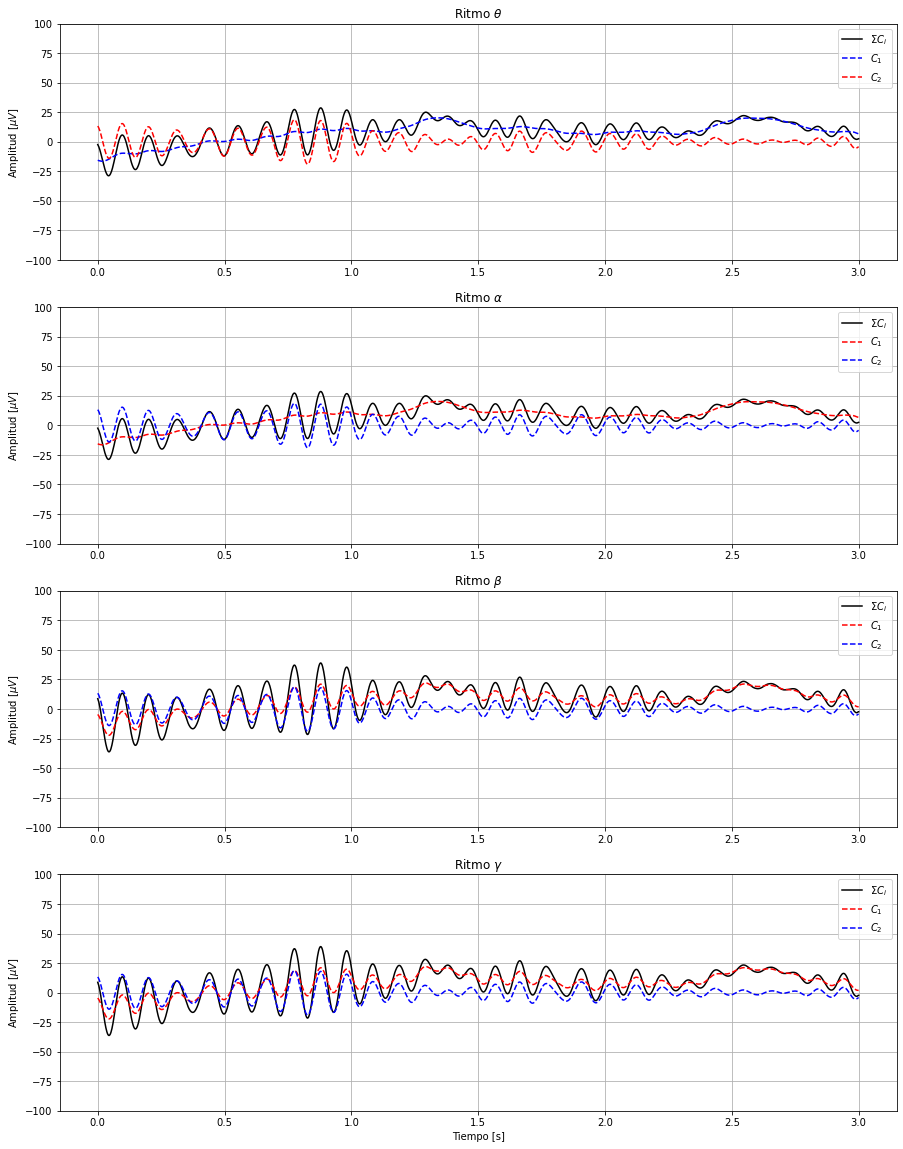

In [39]:
time=np.linspace(0,3,n_points)
fig,ax = plt.subplots(4,1,figsize=(15,20))

ax[0].plot(time,teta_c1+teta_c2,c='black',label='$\Sigma C_i$')
ax[0].plot(time,teta_c1,'--',color='blue',label='$C_1$')
ax[0].plot(time,teta_c2,'--',color='red',label='$C_2$')
# ax[0].set_xlabel('Tiempo [s]')
ax[0].set_ylabel('Amplitud [$\mu V$]')
ax[0].set_title(r'Ritmo $\theta$')
ax[0].set_ylim(-100,100)
ax[0].legend()
ax[0].grid()

ax[1].plot(time,alfa_c1+alfa_c2,c='black',label='$\Sigma C_i$')
ax[1].plot(time,alfa_c1,'--',color='red',label='$C_1$')
ax[1].plot(time,alfa_c2,'--',color='blue',label='$C_2$')
# ax[1].set_xlabel('Tiempo [s]')
ax[1].set_ylabel('Amplitud [$\mu V$]')
ax[1].set_title(r'Ritmo $\alpha$')
ax[1].set_ylim(-100,100)
ax[1].legend()
ax[1].grid()

ax[2].plot(time,beta_c1+beta_c2,c='black',label='$\Sigma C_i$')
ax[2].plot(time,beta_c1,'--',color='red',label='$C_1$')
ax[2].plot(time,beta_c2,'--',color='blue',label='$C_2$')
# ax[2].set_xlabel('Tiempo [s]')
ax[2].set_ylabel('Amplitud [$\mu V$]')
ax[2].set_title(r'Ritmo $\beta$')
ax[2].set_ylim(-100,100)
ax[2].legend()
ax[2].grid()

ax[3].plot(time,gama_c1+gama_c2,c='black',label='$\Sigma C_i$')
ax[3].plot(time,gama_c1,'--',color='red',label='$C_1$')
ax[3].plot(time,gama_c2,'--',color='blue',label='$C_2$')
ax[3].set_xlabel('Tiempo [s]')
ax[3].set_ylabel('Amplitud [$\mu V$]')
ax[3].set_title(r'Ritmo $\gamma$')
ax[3].set_ylim(-100,100)
ax[3].legend()
ax[3].grid()
plt.show()

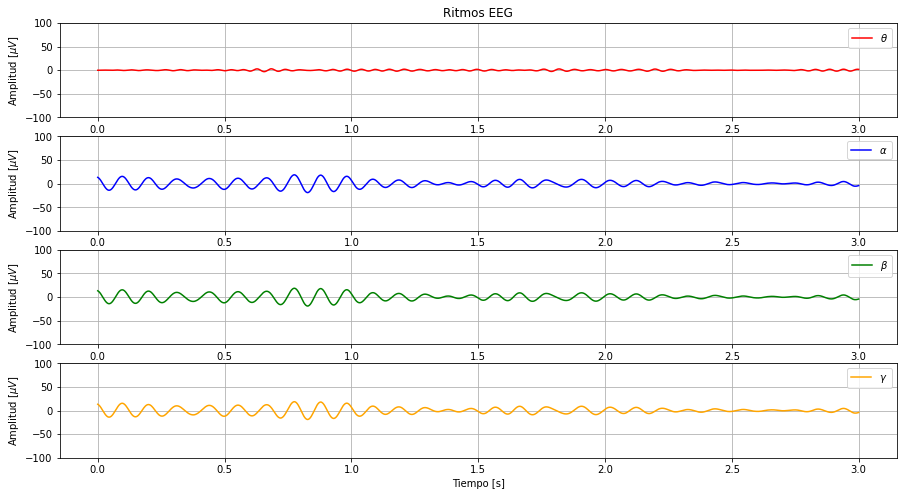

In [40]:
time=np.linspace(0,3,n_points)
fig,ax = plt.subplots(4,1,figsize=(15,8))


ax[0].plot(time,gklist[5],'-',color='red',label=r'$\theta$')
# ax[0].set_xlabel('Tiempo [s]')
ax[0].set_ylabel('Amplitud [$\mu V$]')
ax[0].set_title(r'Ritmos EEG')
ax[0].set_ylim(-100,100)
ax[0].legend()
ax[0].grid()


ax[1].plot(time,alfa_c2,'-',color='blue',label=r'$\alpha$')
# ax[1].set_xlabel('Tiempo [s]')
ax[1].set_ylabel('Amplitud [$\mu V$]')
# ax[1].set_title(r'Ritmo $\alpha$')
ax[1].set_ylim(-100,100)
ax[1].legend()
ax[1].grid()


ax[2].plot(time,beta_c2,'-',color='green',label=r'$\beta$')
# ax[2].set_xlabel('Tiempo [s]')
ax[2].set_ylabel('Amplitud [$\mu V$]')
# ax[2].set_title(r'Ritmo $\beta$')
ax[2].set_ylim(-100,100)
ax[2].legend()
ax[2].grid()


ax[3].plot(time,gama_c2,'-',color='orange',label=r'$\gamma$')
ax[3].set_xlabel('Tiempo [s]')
ax[3].set_ylabel('Amplitud [$\mu V$]')
# ax[3].set_title(r'Ritmo $\gamma$')
ax[3].set_ylim(-100,100)
ax[3].legend()
ax[3].grid()
plt.show()

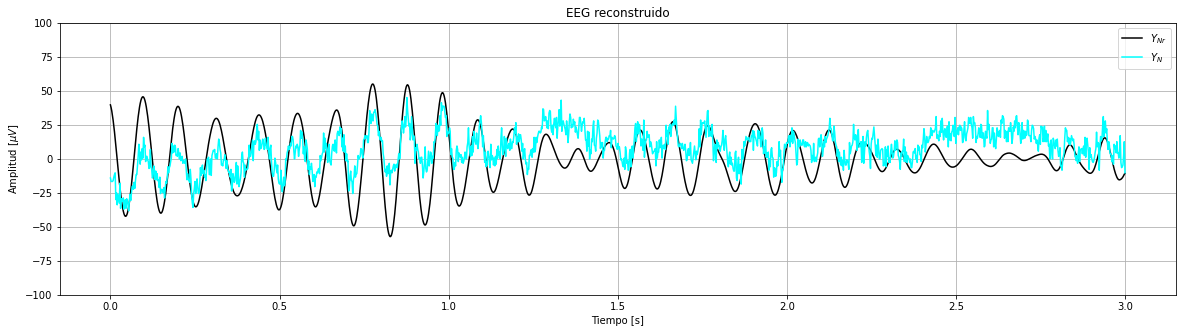

In [41]:
time=np.linspace(0,3,n_points)
fig,ax = plt.subplots(1,1,figsize=(20,5))

ax.plot(time,gklist[5]+alfa_c2+beta_c2+gama_c2,'-',color='black',label='$Y_{Nr}$')
ax.plot(time,eeg,color='cyan',label='$Y_N$')
# ax.plot(time,gklist[5]+alfa_c2+beta_c2+gama_c2-eeg,'-',color='red',label='error')
# ax.plot(time,teta_c2,'--',color='red',label=r'$\theta$')
# ax.plot(time,alfa_c2,'--',color='blue',label=r'$\alpha$')
# ax.plot(time,beta_c2,'--',color='green',label=r'$\beta$')
# ax.plot(time,gama_c2,'-',color='orange',label=r'$\gamma$')
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Amplitud [$\mu V$]')
ax.set_title(r'EEG reconstruido')
ax.set_ylim(-100,100)
ax.legend()
ax.grid()

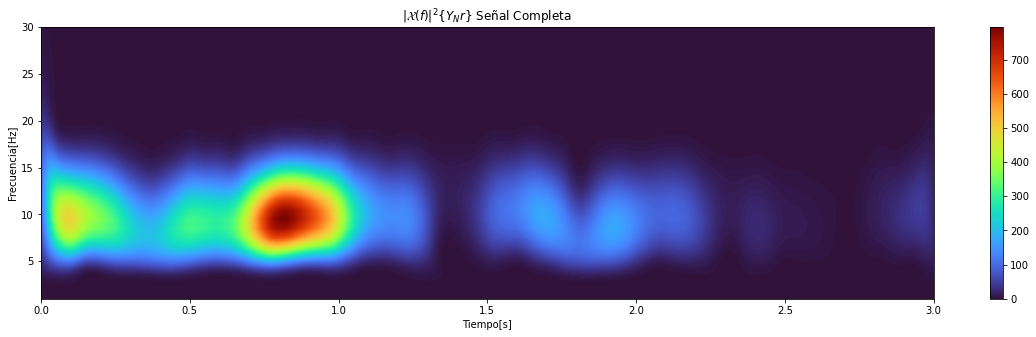

In [42]:
new_eeg = alfa_c2+beta_c2+gama_c2
time=np.linspace(0,3,n_points)
fi = 1 #frecuencia inicial
ff = 30 #frecuencia final
resf = 0.2 #resolución espectral
time_s = 3 #tiempo en segundos de la señal
fig,ax = plt.subplots(1,1,figsize=(20,5))


T_WD = wv.MRA(new_eeg,fi,ff,resf,wv.morlet,500)
ax.imshow(T_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo')
ax.set_xlabel('Tiempo[s]')
ax.set_ylabel('Frecuencia[Hz]')
ax.set_title(r'$|\mathcal{X}(f)|^2 \{ Y_Nr \}$ Señal Completa')
fig.colorbar(plt.imshow(T_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo'))
ax.invert_yaxis()
plt.show()

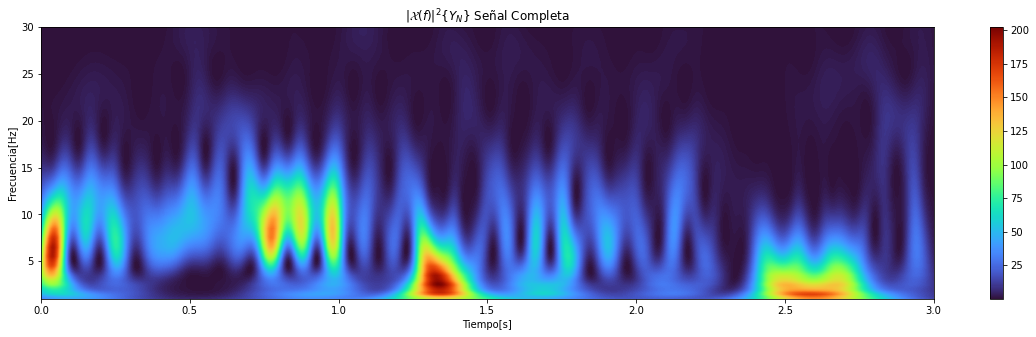

In [43]:

time=np.linspace(0,3,n_points)
fi = 1 #frecuencia inicial
ff = 30 #frecuencia final
resf = 0.2 #resolución espectral
time_s = 3 #tiempo en segundos de la señal
fig,ax = plt.subplots(1,1,figsize=(20,5))


T_WD = wv.MRA(eeg,fi,ff,resf,wv.morlet,500)
ax.imshow(T_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo')
ax.set_xlabel('Tiempo[s]')
ax.set_ylabel('Frecuencia[Hz]')
ax.set_title(r'$|\mathcal{X}(f)|^2 \{ Y_N \}$ Señal Completa')
fig.colorbar(plt.imshow(T_WD,extent=[0,time_s,ff,fi],interpolation='bilinear',aspect='auto',cmap='turbo'))
ax.invert_yaxis()
plt.show()

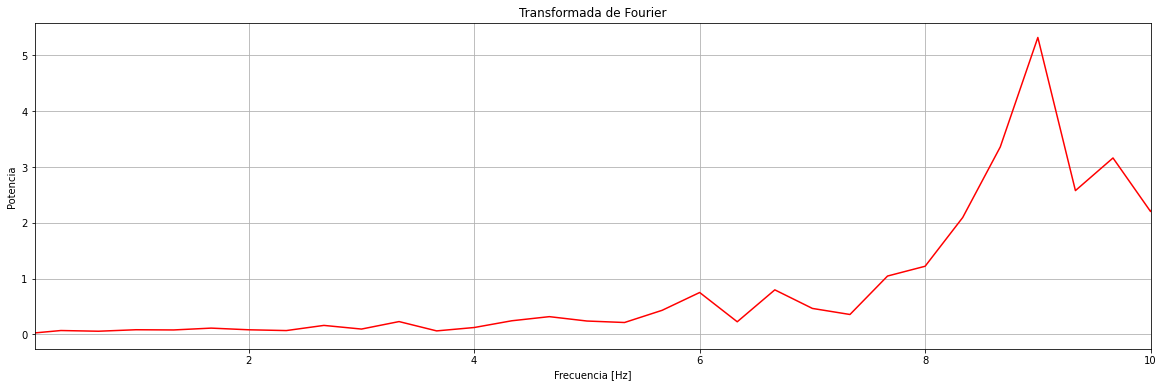

In [44]:
tl.FFT(teta_c2,500,10)